In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
# from mplfinance import candlestick_ohlc
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np

from os.path import exists

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline
from decimal import *
getcontext().prec = 6

import seaborn as sns
# Apply the default theme
sns.set_theme()


matplotlib.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})


In [ ]:
df = pd.read_json(r'./freq-user-data/data/binance/ALGO_USDT-1h.json')
df.columns = ['ts', 'o', 'h', 'l', 'c', 'v']

df['date'] = pd.to_datetime(df['ts'], unit='ms', utc=False)
# df['date'] = pd.to_datetime(df['date'], unit='s', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
df = df.sort_index()

# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
# df

In [293]:
df['lo'] = df.o.apply(np.log)
df['lh'] = df.h.apply(np.log)
df['ll'] = df.l.apply(np.log)
df['lc'] = df.c.apply(np.log)

df['ma1'] = df.c.ewm(span=14, adjust=False).mean()
df['ma2'] = df.c.ewm(span=26, adjust=False).mean()
df['ma3'] = df.c.ewm(span=50, adjust=False).mean()

df['lma1'] = df.lc.ewm(span=14, adjust=False).mean()
df['lma2'] = df.lc.ewm(span=26, adjust=False).mean()
df['lma3'] = df.lc.ewm(span=50, adjust=False).mean()


df['fair_c_ma1'] = df.lc - df.lma1
df['fair_c_ma2'] = df.lc - df.lma2
df['fair_c_ma3'] = df.lc - df.lma3

df['fair_ma1_ma2'] = df.lma1 - df.lma2
df['fair_ma2_ma3'] = df.lma2 - df.lma3
df['fair_ma1_ma3'] = df.lma1 - df.lma3

df['lret'] = df.c.apply(np.log).diff()
df = df.tail(-50).copy()

In [274]:
cond_mav_above = (df.lma2 > df.lma3)
cond_mav_below = (df.lma2 <= df.lma3)
# df['lma23_cross_up'] 
cond_beg = ( cond_mav_above & cond_mav_below.shift(fill_value=False) )
g_beg = cond_beg.cumsum()
# df['lma23_cross_dn']
cond_end = ( (g_beg > 0) & cond_mav_below & cond_mav_above.shift(fill_value=False) )

g_beg = cond_beg.cumsum()
g_end = cond_end.cumsum()
g_inside = (g_beg > g_end)
df['g_beg'] = g_beg
df['g_end'] = g_end
df['g_cond_beg_end'] = (cond_beg | cond_end)
df['g_inside'] = g_inside 
df_inside = df[g_inside].copy()

pos_groups = df_inside.groupby(['g_beg'])
df_inside.loc[pos_groups.head(1).index, 'lret'] = 0.
df_inside['inlret'] = pos_groups['lret'].cumsum(axis=0)
r_pos_groups = df_inside[::-1].groupby(['g_beg'])
df_inside['r_inlret'] = r_pos_groups['lret'].cumsum(axis=0)[::-1]

r_df_inside = df_inside[::-1]
r_pos_groups = r_df_inside.groupby(['g_beg'])
df_inside['max_r_inlret'] = r_pos_groups['r_inlret'].cummax(axis=0)[::-1]
df_inside['min_r_inlret'] = r_pos_groups['r_inlret'].cummin(axis=0)[::-1]
# df_inside['r_inlret'] =  pos_groups['lret'].transform(lambda x: x[::-1].cumsum()[::-1])
# df_inside['r_inlret'] = pos_groups['lret'][::-1].cumsum(axis=0)[::-1]

df.loc[g_inside, 'inlret'] = df_inside['inlret']
df.loc[g_inside, 'r_inlret'] = df_inside['r_inlret']
df.loc[g_inside, 'max_r_inlret'] = df_inside['max_r_inlret']
df.loc[g_inside, 'min_r_inlret'] = df_inside['min_r_inlret']



<ipython-input-312-137b874106a7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_inside = df[g_inside].copy()
/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


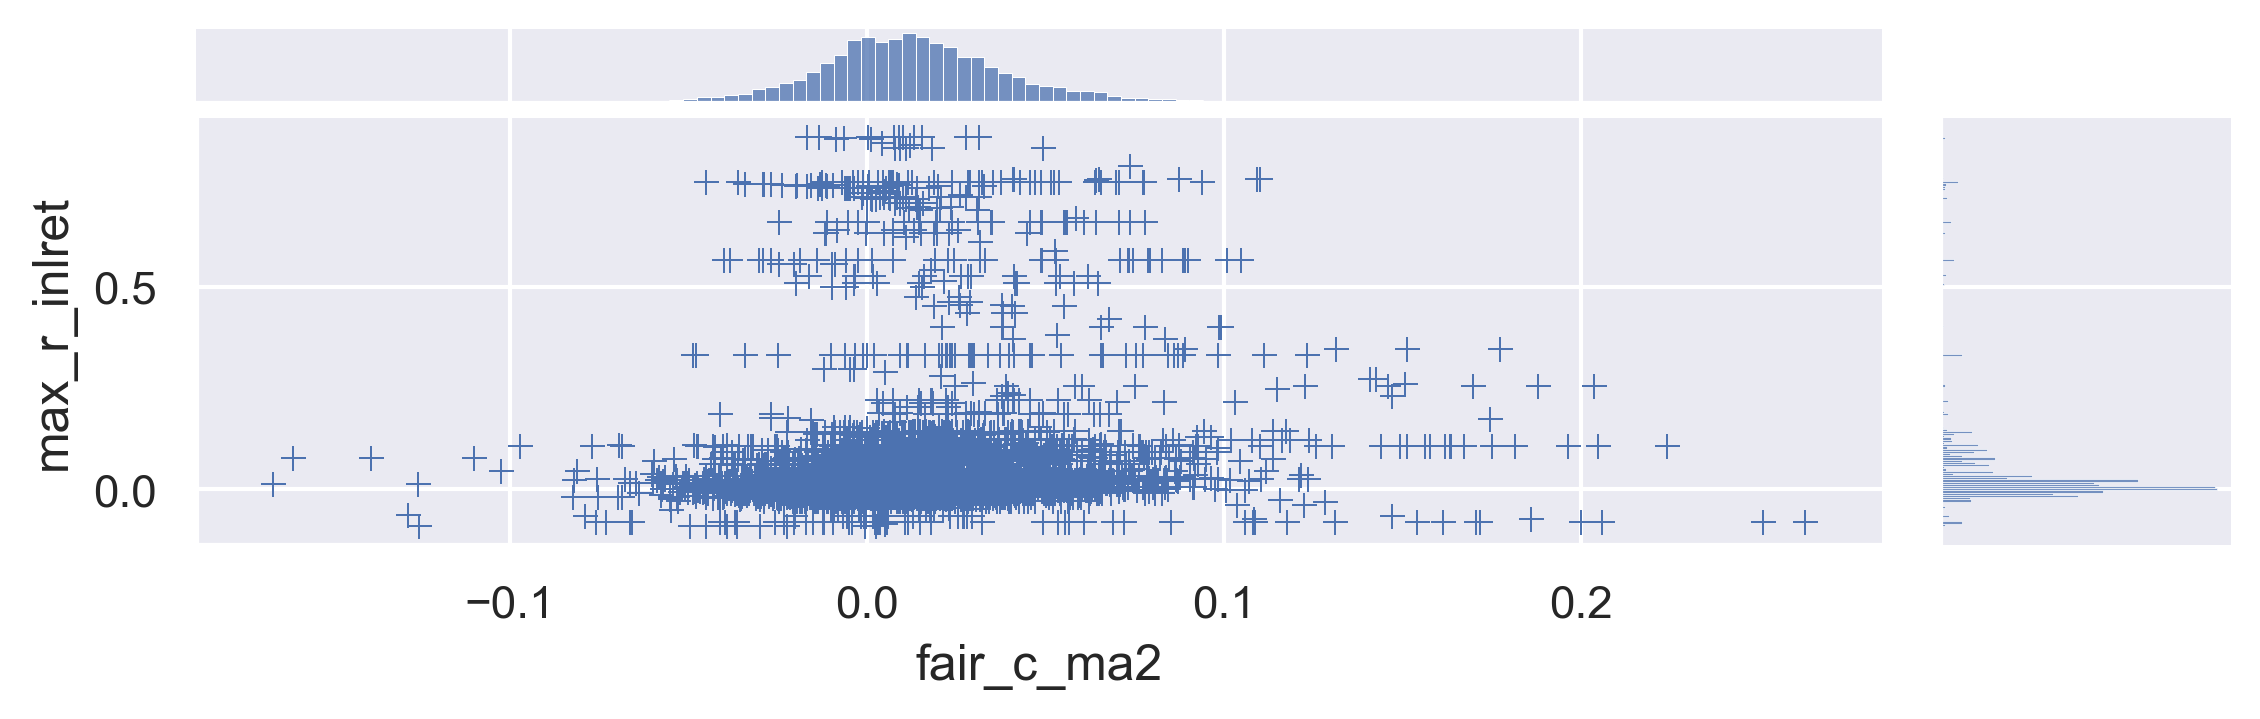

In [312]:
df_inside = df[g_inside].copy()
# sns.set(rc={"figure.figsize":(3, 4)})
# plt.figure(figsize=(12, 2))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# plt.figure(figsize=(15,4))
# sns.displot(ret_r2r, bins=100)
# sns.displot(max_rets, bins=100)
# sns.displot(min_rets, bins=100)
# sns.displot(df_inside, x="fair_c_ma2", y="max_r_inlret", kind="kde")

# sns.displot(df_inside, x="fair_c_ma2", y="max_r_inlret", binwidth=(0.005, .01), cbar=True)
# sns.displot(df_inside, x="fair_ma2_ma3", y="max_r_inlret", binwidth=(0.005, .01), cbar=True)

sns.jointplot(data=df_inside, x="fair_c_ma2", y="max_r_inlret", marker="+")
plt.gcf().set_size_inches(8, 2)
# ret_r2r

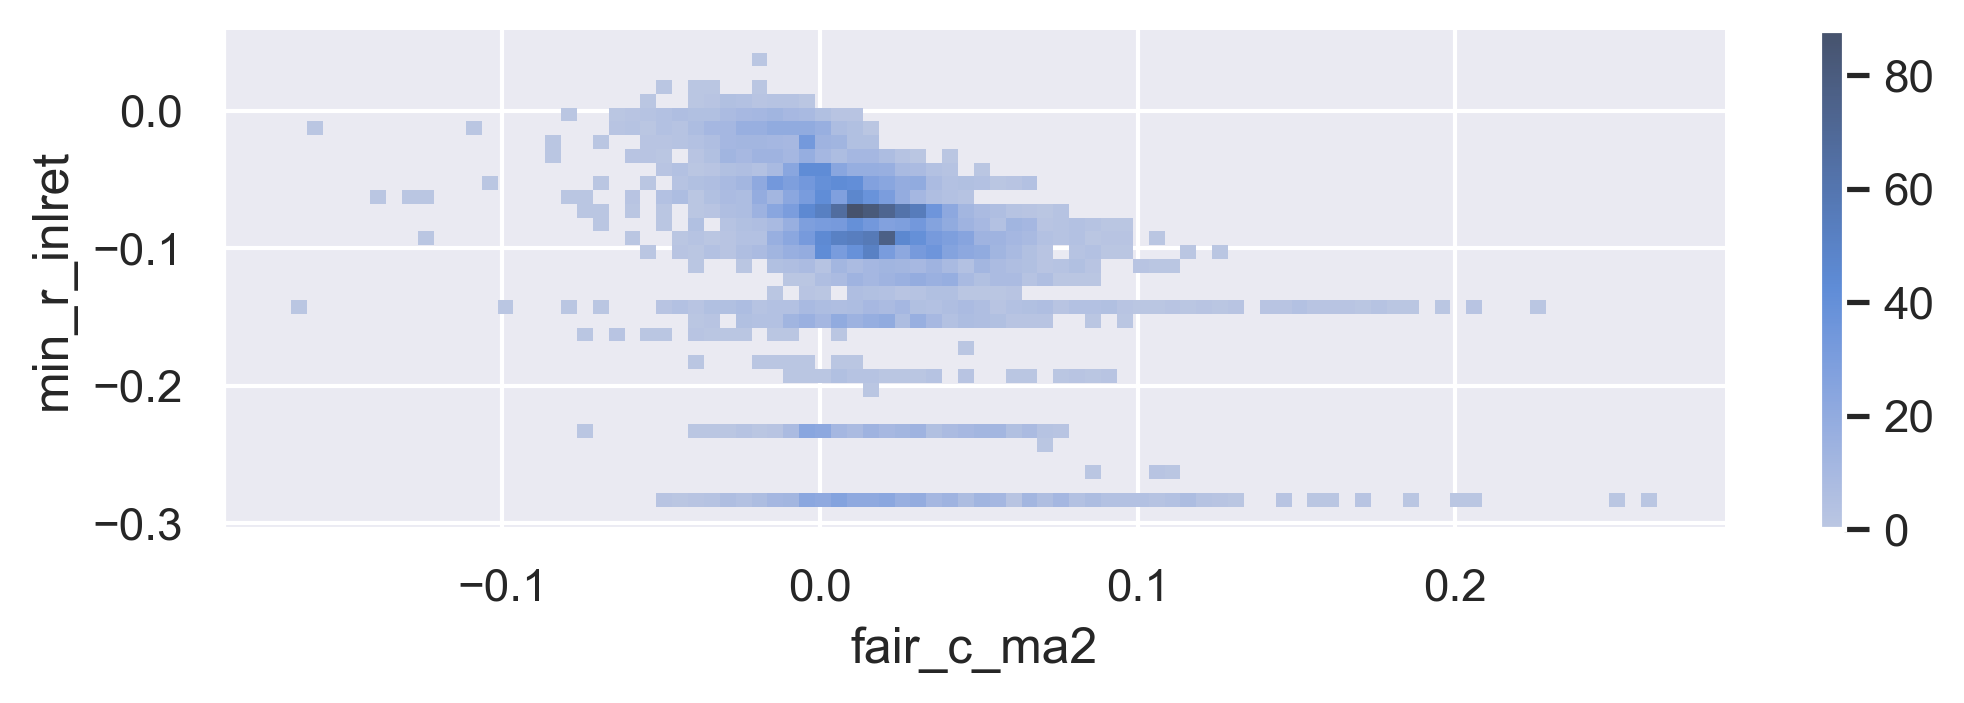

In [316]:

# sns.displot(df_inside, x="fair_c_ma2", y="min_r_inlret", binwidth=(0.005, .01), cbar=True)
sns.displot(df_inside, x="fair_c_ma2", y="min_r_inlret", binwidth=(0.005, .01), cbar=True)
# sns.jointplot(data=df_inside, x="fair_c_ma2", y="min_r_inlret")

# sns.jointplot(data=df_inside, x="fair_c_ma1", y="min_r_inlret", marker="+")
plt.gcf().set_size_inches(8, 2)

In [282]:
# %%capture
strategy = 'i-emas-stats'
strategy_params_json = f'./strategy-params/{strategy}.json'

fee:float = 0.001
# capital = 10000
# risk_per_trade_perc = 0.01
# risk = 0.01
ddf = df
dlen = len(ddf)

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

strategy_params = {
    # 'mav1': {'type': 'int', 'value': 21, 'step': 1},
    # 'mav2': {'type': 'int', 'value': 50, 'step': 1},
    # 'mav3': {'type': 'int', 'value': 50, 'step': 5},
    # 'mav1mav2': {'type': 'float', 'value': 0.01, 'step': 0.0005},
    # 'mav2mav3': {'type': 'float', 'value': 0.01, 'step': 0.0005},
    # 'stop_gap': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'slipage': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'risk': {'type': 'float', 'value': 0.01, 'step': 0.005},
    # 'sl': {'type': 'float', 'value': 0.01, 'step': 0.001},
    # 'r2r': {'type': 'float', 'value': 2./1., 'step': 0.05},
    # 'wbtp': {'type': 'float', 'value': 0.1, 'step': 0.05},
    # 'trail': {'type': 'float', 'value': 0.02, 'step': 0.005},
}
for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {"w2log": {'wdg': sl_n2}, "w": {'wdg': sl_w}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wst = wed = wsz = False
wdf = wadf = False

def printer(w2log, w):
    # global capital
    capital = 10000
    global wst, wed, wsz, wdf
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)

    
    plt.close("all")
    vlines=list(wdf[wdf['g_cond_beg_end']].index.astype('string').values)

    with plt.rc_context():
        kwargs = dict(warn_too_much_data=100000)

        wdf = wdf.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'})
        fig = plt.figure(constrained_layout=True,figsize=(16,5))
        gs0 = fig.add_gridspec(1, 2, width_ratios=[3,1])

        gs00 = gs0[0,0].subgridspec(3, 1, height_ratios=[3,1,1])
        gs01 = gs0[0,1].subgridspec(4, 1)

        ax001 = fig.add_subplot(gs00[0,0])
        ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
        ax003 = fig.add_subplot(gs00[2,0], sharex=ax001)

        ax101 = fig.add_subplot(gs01[0,0])
        ax102 = fig.add_subplot(gs01[1,0])
        ax103 = fig.add_subplot(gs01[2,0])
        
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax001.xaxis.set_major_locator(locator)
        ax001.xaxis.set_major_formatter(formatter)

        mpf.plot(wdf,
            **{**kwargs, **dict(volume=False, style='binance',type='candle')},  #figsize=(15, 5)
            show_nontrading=True,
            vlines=dict(vlines=vlines, linewidths=(1,0.5), colors=('g','c'), linestyle='-.'),
            ax=ax001,
            # vlines=['2021-03-15 04:00:00'],
            # addplot=ap2
            )
        ax001.plot(wdf.ma1, color='orange')
        ax001.plot(wdf.ma2, color='green')
        ax001.plot(wdf.ma3, color='blue')
        
        max_in_lret = wdf[['inlret', 'r_inlret']].max().max()
        min_in_lret = wdf[['inlret', 'r_inlret']].min().min()
        ax002.plot(wdf.r_inlret, lw=1, color='r')
        ax002.plot(wdf.max_r_inlret, lw=1, color='g', linestyle='dashed')
        ax002.plot(wdf.min_r_inlret, lw=1, color='r', linestyle='dashed')
        ax002.vlines(wdf[wdf.g_cond_beg_end].index, min_in_lret, max_in_lret, lw=0.5, color="c")

        ax003.plot(wdf.fair_c_ma2, lw=1, color='g')
       
    plt.show()
    
if exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];
                                        

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)

Output()

In [271]:
wdf[['inlret', 'r_inlret']].max().max()

0.05823055794851906

In [ ]:
# df['mdate'] = [mdates.date2num(d) for d in df['date']]
wdf['mdate'] = wdf.date.apply(mdates.date2num)
# pd.to_datetime(wdf['date'], unit='s')